In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# installing neccesory dependency
!pip install -q tensorflow-probability
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
# importing librery
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import tensorflow as tf
import tensorflow_probability as tfp

In [4]:
# loading dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [5]:
type(train_images)

numpy.ndarray

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_images.shape[0]

60000

In [8]:
# function for doing preprocessing
def preprocess_image(images):
  images = images.reshape(images.shape[0], 28,28,1) / 255.0 
  return np.where(images > 0.5, 1.0, 0.0).astype('float32')

In [9]:
train_images = preprocess_image(train_images)
test_images = preprocess_image(test_images)

In [10]:
train_images.shape

(60000, 28, 28, 1)

In [11]:
test_images.shape

(10000, 28, 28, 1)

In [12]:
# defining variables
train_size = 60000
test_size = 10000
batch_size = 32

In [13]:
# transforming numpy array to tf.dataset so it can be proceesed by tensorflow faster then shuffling and creating batch
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size) )

In [108]:
# creating Convolutional Variational AutoEncoder
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(28,28,1)),
      tf.keras.layers.Conv2D(
          filters=32, kernel_size=3, strides=(2,2), activation='relu'
      ),
      tf.keras.layers.Conv2D(
          filters=64, kernel_size=3, strides=(2,2), activation='relu'
      ),
      tf.keras.layers.Flatten(),
      # No activation
      tf.keras.layers.Dense(latent_dim + latent_dim)
    ])
    self.decoder = tf.keras.Sequential(
    [
      tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
      tf.keras.layers.Dense(units=7*7*32, activation='relu'),
      tf.keras.layers.Reshape(target_shape=(7,7,32)),
      tf.keras.layers.Conv2DTranspose(
          filters=64, kernel_size=3, strides=2, padding='same',
          activation='relu'
      ),
      tf.keras.layers.Conv2DTranspose(
          filters=32, kernel_size=3, strides=2, padding='same',
          activation='relu'
      ),
      # no activation
      tf.keras.layers.Conv2DTranspose(  
          filters=1, kernel_size=3, strides=1, padding='same'
      )
    ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps in None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
  
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * 0.5) + mean
  
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
    

In [109]:
# defining optimiser
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
  axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradient(zip(gradients, model.trainable_variables))


In [110]:
epochs = 10
latent_dim = 2
num_examples_to_generate = 16

In [111]:
ramdom_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)
model = CVAE(latent_dim)

In [112]:
def generate_and_save_images(model, epochs, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  prediction = model.decode(z)

  fig = plt.figure(figsize=(4,4))

  for i in range(prediction.shape[0]):
    plt.subplot(4,4, i+1)
    plt.imshow(prediction[i, :,:, 0], cmap='gray')
    plt.axis('off')
  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epochs))
  plt.show()

In [113]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

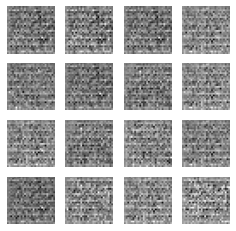

In [116]:
generate_and_save_images(model, 1, test_sample)

In [115]:
for epoch in range(1, epochs+1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

